# I'm Dreaming of a White Christmas
## Written By Jared Rennie (@jjrennie)

Have you wondered if you got a White Christmas on a particular year? This notebook will help you answer that question. We will be using data from <a href='http://www.ncei.noaa.gov' target='_blank'> NOAA's National Centers of Environmental Information</a>, specifically the Global Historical Climatology Network - Daily Dataset: 

- GHCNd Info: https://www.ncei.noaa.gov/products/global-historical-climatology-network-daily
- GHCNd AWS Location: https://registry.opendata.aws/noaa-ghcn/

In addition to answering the question, you will learn how to get data from the cloud and plot it, without actually reading in the entire dataset!

### What's the Criteria Used?
We will use criteria defined by our National Weather Service Colleague <a href='https://bsky.app/profile/climatologist49.bsky.social' target='_blank'>Brian Brettschneider</a>:
<img src="./NYC_SNOW.png" alt="NYC Central Park" style="height: 600px; width:544px;"/>
- No snow on the ground but new snowflall.
- 1-3" of snow on the ground.
- More than 3" of snow on the ground.

### What You Need
First off, the entire codebase works in Python 3. In addition to base Python, you will need the following packages installed: 
- pandas (to slice annd dice the data)
- geopandas (to read in some shapefiles)
- pyarrow or fastparquet (for the parquet data ingest)
- matplotlib and cartopy (to plot)
  
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
%matplotlib inline

# Import Packages
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.dataset as ds

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

print("SUCCESS!")

SUCCESS!


If you made it this far, great!

### Insert Arguments
We need 2 arguments, the first is the year in question, and the second is the creator of the map

 **Change the arguments below to your liking**

In [2]:
# Insert Arguments Here
inYear=2025
author='NOT JARED RENNIE'

### Get Stations and Associated Metadata
The GHCNd database has over 100,000 stations across the globe, and not all of them report snow or snow depth. We are also only looking at stations in the US and Canada, so we need to filter down the stations we need. This block of code will do that, including getting some metadata we need for plotting later, like latitude, longitude, and state.

Bad news is that GHCNd has 2 metadata files to get this info (don't ask me why) but we will get both files and join everything we need into 1 dataframe.

In [3]:
%%time

#################################
# FILE ONE: GHCNd Station File
stnUrl = "https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt"

# Define the columns we need from the stations file:
# ID: 0-11, STATE: 38-40 (39th-40th character)
station_colspecs = [(0, 11), (38, 40)]
station_colnames = ["ID", "STATE"]

# Read the fixed-width file
ghcn_meta1 = pd.read_fwf(stnUrl, colspecs=station_colspecs, names=station_colnames)

#################################
# FILE TWO: GHCNd Inventory File
invUrl = "https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt"

# Define column names and widths (fixed-width format)
inventory_colspecs = [(0, 11), (12, 20), (21, 30), (31, 35), (36, 40), (41, 45)]
inventory_colnames = ["ID", "LAT", "LON", "element", "first_year", "last_year"]

# Read the fixed-width file
ghcn_meta2 = pd.read_fwf(invUrl, colspecs=inventory_colspecs, names=inventory_colnames)

#################################
# JOIN
ghcn_meta = ghcn_meta2.merge(ghcn_meta1, on="ID", how="left")
ghcn_meta

CPU times: user 5.27 s, sys: 226 ms, total: 5.5 s
Wall time: 5.92 s


,ID,LAT,LON,element,first_year,last_year,STATE
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949,NaN
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949,NaN
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949,NaN
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949,NaN
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949,NaN
...,...,...,...,...,...,...,...
767622,ZI000067983,-20.2000,32.6160,PRCP,1951,2025,NaN
767623,ZI000067983,-20.2000,32.6160,TAVG,1962,2025,NaN
767624,ZI000067991,-22.2170,30.0000,TMAX,1951,1990,NaN
767625,ZI000067991,-22.2170,30.0000,TMIN,1951,1990,NaN


Now we will filter stations so that
- They occurr in the US or Canada (note that "RQ" is Puerto Rico here)
- They report both Snowfall (SNOW) and Snow Depth (SNWD) for the year in question

In [4]:
%%time

# Function to filter out stations to use in project
def get_snow_stations(df, inYear):
    df = df[df["ID"].str.startswith(("US", "CA", "RQ"))]
    df = df[df["element"].isin(["SNOW", "SNWD"])]
    df = df[(df["first_year"] <= inYear) & (df["last_year"] >= inYear)]

    valid_ids = (
        df.groupby("ID")["element"]
        .nunique()
        .loc[lambda x: x == 2]
        .index
    )
    df=df[df["ID"].isin(valid_ids)].reset_index()
    df = df.drop(['element','index','first_year','last_year'], axis=1)
    df=df.drop_duplicates(subset="ID").reset_index(drop=True)
    return df
    
# Call Function and print out results
inStns = get_snow_stations(ghcn_meta, inYear)
stations = set(inStns["ID"])
inStns

CPU times: user 320 ms, sys: 26.4 ms, total: 346 ms
Wall time: 345 ms


,ID,LAT,LON,STATE
0,CA1AB000002,53.5694,-113.4376,AB
1,CA1AB000024,50.5638,-111.8985,AB
2,CA1AB000054,51.3346,-114.3037,AB
3,CA1AB000064,53.4435,-113.5607,AB
4,CA1AB000120,49.0399,-113.1536,AB
...,...,...,...,...
13856,USW00094988,42.1106,-92.9164,IA
13857,USW00094989,41.9906,-93.6186,IA
13858,USW00094991,40.6306,-93.9006,IA
13859,USW00094993,45.6689,-96.9919,SD


### Get Snowfall Data for Day in Question
Now that we have the stations, let's grab the data from AWS. It is in parquet format, which makes it much easer to analyze and filter data, without reading in the whole dataset. The parquet data is organized by element and year, so we will build 2 dataframes, one for snowfall (SNOW) and one for snow depth (SNWD), then Join together. The database also has flags for quality and measurement. We will remove data that failed a quality check, and we will save the measurement flag for later. We will consider trace measurements (Measurement Flag of 'T') as a value available for consideration. 

Remember that we need both snowfall and snow depth, so if one is missing it cannot be used. 

In [5]:
%%time

# Format Date based on inYear
target_date=f'{inYear}1225'
outDate=f'{inYear}-12-25'

# Get Snowfall (SNOW) for day in question
dsSnow = ds.dataset(f"s3://noaa-ghcn-pds/parquet/by_year/YEAR={inYear}/ELEMENT=SNOW/",format="parquet")
snow_table = dsSnow.to_table(
    filter=(
        ds.field("ID").isin(stations) &
        (ds.field("DATE") == target_date) &
        ds.field("Q_FLAG").is_null() 
    )
)
outSnow = snow_table.to_pandas()

# Get Snow Depth (SNWD) for day in question
dfSnwd = ds.dataset(f"s3://noaa-ghcn-pds/parquet/by_year/YEAR={inYear}/ELEMENT=SNWD/",format="parquet")
snwd_table = dfSnwd.to_table(
    filter=(
        ds.field("ID").isin(stations) &
        (ds.field("DATE") == target_date) &
        ds.field("Q_FLAG").is_null() 
    )
)
outSnwd = snwd_table.to_pandas()

# Organize and Join. Values are initially in mm, so need to convert to inches
outSnow = outSnow[["ID", "DATA_VALUE", "M_FLAG"]].rename(columns={"DATA_VALUE": "SNOW_VAL","M_FLAG": "SNOW_MFLAG"})
outSnwd = outSnwd[["ID", "DATA_VALUE", "M_FLAG"]].rename(columns={"DATA_VALUE": "SNWD_VAL","M_FLAG": "SNWD_MFLAG"})
outDaily = outSnow.merge(outSnwd, on="ID", how="inner")
outDaily['SNOW_VAL']=outDaily['SNOW_VAL'] * 0.0393701 
outDaily['SNWD_VAL']=outDaily['SNWD_VAL'] * 0.0393701 
outDaily

CPU times: user 389 ms, sys: 69.8 ms, total: 458 ms
Wall time: 1.29 s


,ID,SNOW_VAL,SNOW_MFLAG,SNWD_VAL,SNWD_MFLAG
0,CA1ON000178,0.000000,None,0.000000,T
1,CA1ON000005,0.000000,None,4.488191,None
2,CA1ON000009,0.000000,None,0.000000,None
3,CA1ON000033,0.000000,None,0.984252,None
4,CA1ON000042,1.417324,None,5.984255,None
...,...,...,...,...,...
3378,USC00503275,0.118110,None,20.000011,None
3379,USC00503304,0.000000,None,9.015753,None
3380,USC00503368,1.417324,None,20.000011,None
3381,USC00503502,0.000000,None,10.984258,None


Let's now join the data and metadata.

In [6]:
# Join Metadata and Data
outData = inStns.merge(outDaily, on="ID", how="inner")
outData

,ID,LAT,LON,STATE,SNOW_VAL,SNOW_MFLAG,SNWD_VAL,SNWD_MFLAG
0,CA1AB000120,49.0399,-113.1536,AB,0.000000,T,0.000000,T
1,CA1AB000166,51.7718,-114.4272,AB,0.984252,None,6.299216,None
2,CA1AB000214,51.1475,-114.2298,AB,0.000000,None,0.000000,None
3,CA1AB000228,52.8407,-110.8351,AB,1.692914,None,5.314964,None
4,CA1AB000241,53.4911,-113.5260,AB,4.291341,None,12.007880,None
...,...,...,...,...,...,...,...,...
3378,USW00094908,42.3983,-90.7092,IA,0.000000,None,0.000000,None
3379,USW00094949,40.6003,-98.4264,NE,0.000000,None,0.000000,None
3380,USW00094950,43.7742,-98.0383,SD,0.000000,None,0.000000,None
3381,USW00094982,41.6117,-90.5808,IA,0.000000,None,0.000000,None


Now we will split the results by the 3 criteria defined above: 

- No snow on the ground but new snowflall.
- 1-3" of snow on the ground.
- More than 3" of snow on the ground.

In [7]:
# Get Final Values By Criteria
finalData1=outData[(outData['SNWD_VAL'] == 0)]
finalData1=finalData1[(finalData1['SNOW_VAL'] > 0) | (finalData1['SNOW_MFLAG'] == 'T')]
finalData2=outData[(outData['SNWD_VAL'] >= 1) & (outData['SNWD_VAL'] <= 3) ]
finalData3=outData[outData['SNWD_VAL'] > 3]

Now for the fun part!

## Plot the Data
This block of code plots the data for CONUS, parts of southern Canada, and Alaska, Puerto Rico and Hawaii (could white christmases happen there? one can dream).

Feel free to tinker with this block if you want to change colors, or utilize other areas (like all of Canada).

Plotting No snow on ground but new snowfall (72)
Plotting 1" to 3" snow depth (197)
Plotting Over 3" snow depth (442)


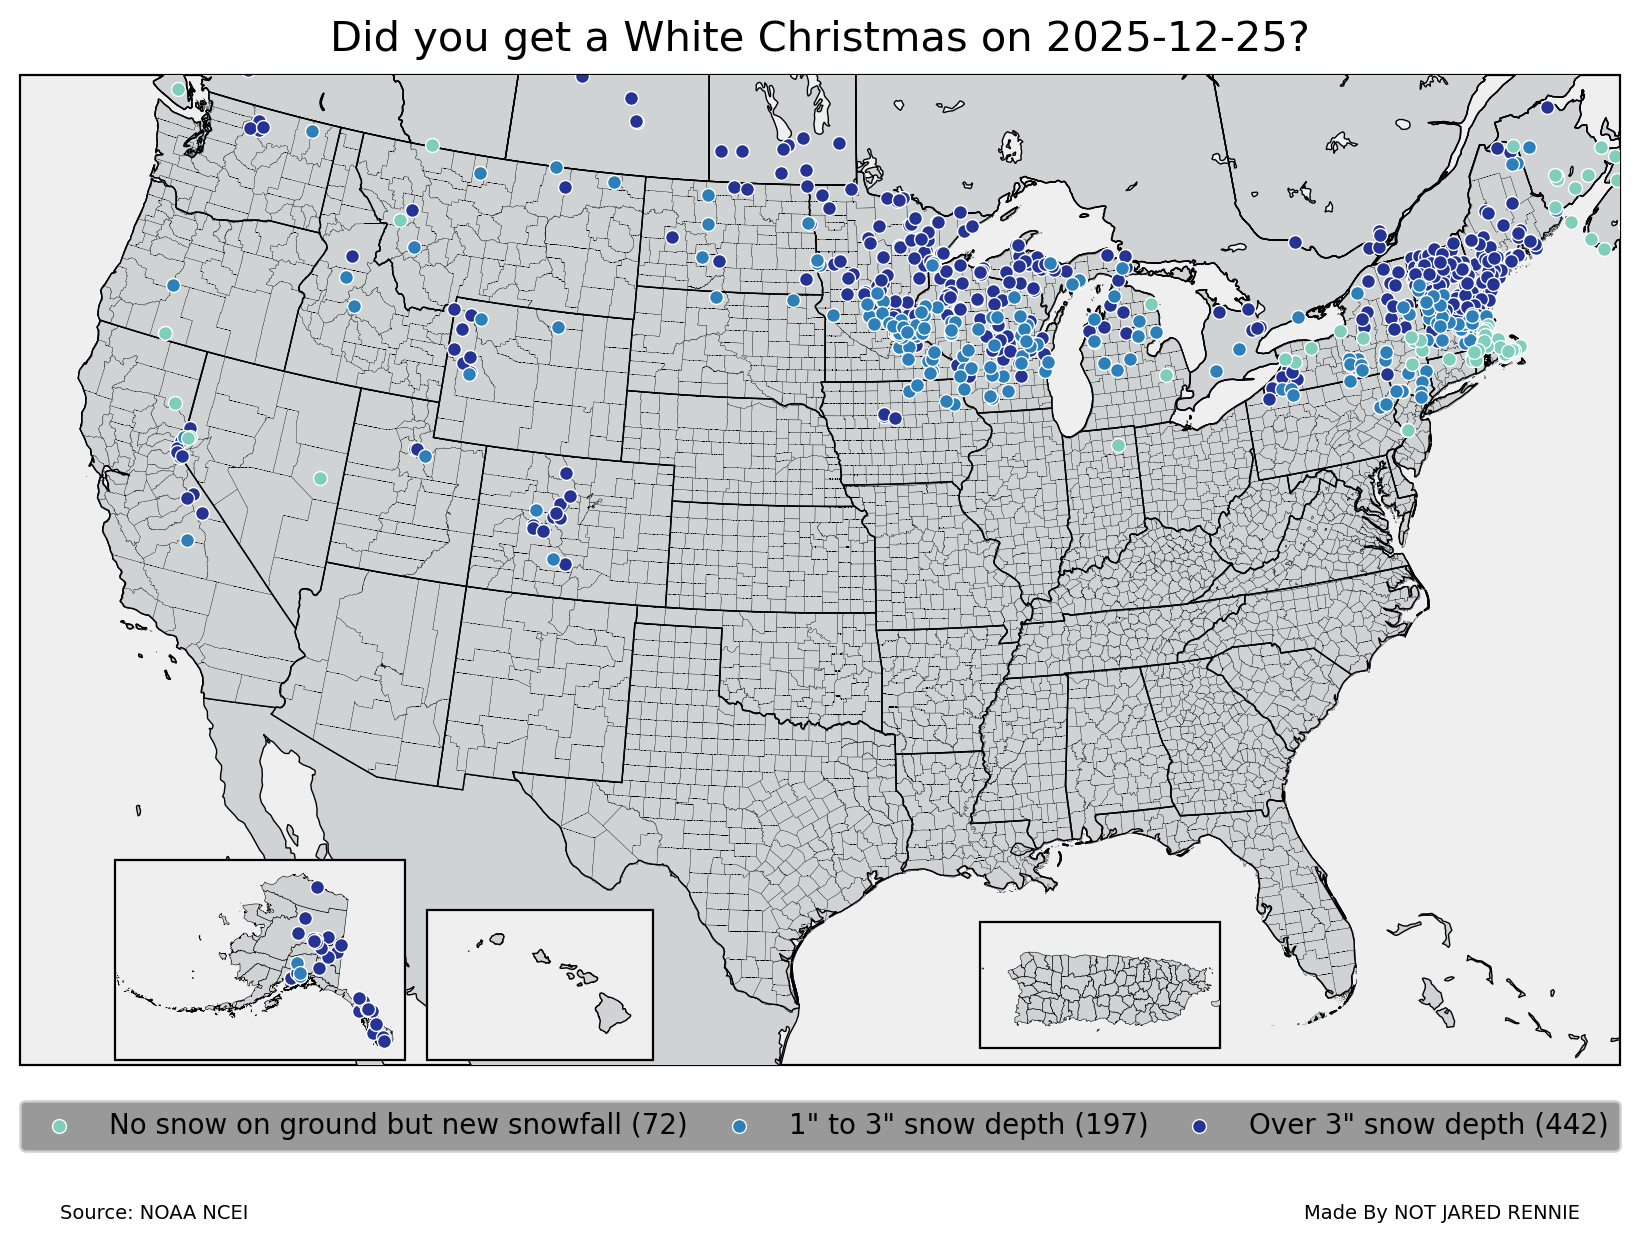

CPU times: user 1min 23s, sys: 142 ms, total: 1min 23s
Wall time: 1min 23s


In [8]:
%%time

#################################################
# PLOTTING SETTINGS
dpi = 200
land_hex = '#cfd3d4'
ocean_hex = '#efefef'
edgecolor = 'black'
outTitle = f'Did you get a White Christmas on {outDate}?'

#################################################
# CREATE FIGURE AND AXES
fig = plt.figure(num=1, figsize=(8, 5), dpi=dpi, facecolor='w', edgecolor='k')

# CONUS
conus_ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
conus_ax.set_facecolor(ocean_hex)
conus_ax.spines['geo'].set_edgecolor(edgecolor)
conus_ax.set_extent([-120, -73, 22, 50], crs=ccrs.Geodetic())

# ALASKA
ak_ax = fig.add_axes([0.05, 0.01, 0.20, 0.20], projection=ccrs.Orthographic(-133.6667, 57))
ak_ax.set_facecolor(ocean_hex)
ak_ax.spines['geo'].set_edgecolor(edgecolor)
ak_ax.set_extent([-184, -128, 53, 67], crs=ccrs.Geodetic())

# HAWAII
hi_ax = fig.add_axes([0.25, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
hi_ax.set_facecolor(ocean_hex)
hi_ax.spines['geo'].set_edgecolor(edgecolor)
hi_ax.set_extent([-162, -154, 18, 23], crs=ccrs.Geodetic())

# PUERTO RICO
pr_ax = fig.add_axes([0.60, 0.01, 0.15, 0.15], projection=ccrs.Mercator())
pr_ax.set_facecolor(ocean_hex)
pr_ax.spines['geo'].set_edgecolor(edgecolor)
pr_ax.set_extent([-67.5, -65.5, 17.75, 18.75], crs=ccrs.Geodetic())

#################################################
# READ IN COUNTY SHAPEFILE
input_shapefile = './input_shapefile/cb_2022_us_county_500k.shp'
geo_shapefile = gpd.read_file(input_shapefile)
geo_shapefile['state_fips'] = geo_shapefile['GEOID'].str[:2]
fips_to_ax = {'02': ak_ax, '15': hi_ax, '72': pr_ax}

# Plot Counties
for geom, state_fips in zip(shpreader.Reader(input_shapefile).geometries(), geo_shapefile['state_fips']):
    ax = fips_to_ax.get(state_fips, conus_ax)
    lw = 0.50 if state_fips == '15' else 0.20 if state_fips in ['02', '72'] else 0.10
    ax.add_geometries([geom], ccrs.PlateCarree(),
                      facecolor=land_hex, edgecolor=edgecolor,
                      linewidth=lw, zorder=6)

# Add Additional Features
conus_ax.add_feature(cfeature.LAND, linewidth=0.5, facecolor=land_hex, edgecolor=edgecolor, zorder=3)
conus_ax.add_feature(cfeature.LAKES, linewidth=0.5, facecolor=ocean_hex, edgecolor=edgecolor, zorder=4)
conus_ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor=edgecolor, zorder=5)
conus_ax.add_feature(cfeature.STATES,linewidth=0.5,edgecolor=edgecolor,zorder=7)

#################################################
# SCATTER PLOTTING (GROUPED BY STATE)

criteria = [
    (finalData1, '#7fcdbb', 10, f'No snow on ground but new snowfall ({len(finalData1)})'),
    (finalData2, '#2c7fb8', 9, f'1" to 3" snow depth ({len(finalData2)})'),
    (finalData3, '#253494', 8, f'Over 3" snow depth ({len(finalData3)})'),
]

for df, color, zorder, label in criteria:
    print(f'Plotting {label}')
    # Add dummy scatter for legend
    conus_ax.scatter(0, 0, marker='o', s=25, color=color,
                     edgecolors='white', linewidths=0.5,
                     transform=ccrs.PlateCarree(), zorder=zorder, label=label)
    
    # Group by state for plotting
    for state, group in df.groupby('STATE'):
        ax = {'AK': ak_ax, 'HI': hi_ax, 'PR': pr_ax}.get(state, conus_ax)
        ax.scatter(group['LON'].values, group['LAT'].values, marker='o', s=25,
                   color=color, edgecolors='white', linewidths=0.5,
                   transform=ccrs.PlateCarree(), zorder=zorder)

#################################################
# LEGEND AND TITLES
conus_ax.legend(bbox_to_anchor=(0., -.087, 1., -1.02), loc=3, ncol=3, mode="expand",borderaxespad=0., fontsize=10, facecolor='#808080')
plt.suptitle(outTitle, size=15, color='black', y=1.05)
conus_ax.annotate('Source: NOAA NCEI',xy=(0.025, -0.16), xycoords='axes fraction', fontsize=7,color='black', horizontalalignment='left', verticalalignment='bottom')
conus_ax.annotate('Made By '+author, xy=(0.975, -0.16), xycoords='axes fraction', fontsize=7,color='black', horizontalalignment='right', verticalalignment='bottom')
plt.show()

SNOMG!!!! Now you know if there was a White Christmas! Hopefully it was merry and bright!

**Congrats on completing this notebook! Now go forth and make better plots!**